# Self made RP3-beta

In [39]:
import helpers
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import defaultdict
from itertools import chain
import random
import time
import matplotlib.pyplot as plt

train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)

In [40]:
class RP3Beta():
    def fit(self, train_ui, alpha, beta):
        """We weight our edges by user's explicit ratings so if user rated movie high we'll follow that path
        with higher probability."""
        self.train_ui=train_ui
        self.train_iu=train_ui.transpose()
        
        self.alpha = alpha
        self.beta = beta
        
        # Define Pui 
        Pui=sparse.csr_matrix(self.train_ui/self.train_ui.sum(axis=1))
        
        # Define Piu
        to_divide=np.vectorize(lambda x: x if x>0 else 1)(self.train_iu.sum(axis=1)) # to avoid dividing by zero
        Piu=sparse.csr_matrix(self.train_iu/to_divide)
        item_orders=(self.train_ui>0).sum(axis=0)
        
        Pui = Pui.power(self.alpha)
        Piu = Piu.power(self.alpha)

        P3=Pui*Piu*Pui
        
        P3/=np.power(np.vectorize(lambda x: x if x>0 else 1)(item_orders), self.beta)
        
        self.estimations=np.array(P3)
    
    def recommend(self, user_code_id, item_code_id, topK=10):
        
        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):
            
            user_rated=self.train_ui.indices[self.train_ui.indptr[nb_user]:self.train_ui.indptr[nb_user+1]]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result=[]
        # Let's choose k best items in the format: (user, item1, score1, item2, score2, ...)
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid]+list(chain(*item_scores[:topK])))
        return result
    
    def estimate(self, user_code_id, item_code_id, test_ui):
        result=[]
        for user, item in zip(*test_ui.nonzero()):
            result.append([user_code_id[user], item_code_id[item], 
                           self.estimations[user,item] if not np.isnan(self.estimations[user,item]) else 1])
        return result

In [41]:
model=RP3Beta()
model.fit(train_ui, alpha=1, beta=0)

In [42]:
top_n=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv('Recommendations generated/ml-100k/Self_P3_reco.csv', index=False, header=False)

estimations=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv('Recommendations generated/ml-100k/Self_P3_estimations.csv', index=False, header=False)

In [44]:
import evaluation_measures as ev
estimations_df=pd.read_csv('Recommendations generated/ml-100k/Self_P3_estimations.csv', header=None)
reco=np.loadtxt('Recommendations generated/ml-100k/Self_P3_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])

943it [00:00, 7582.24it/s]


RMSE       MAE  precision    recall       F_1     F_05  \
0  3.702446  3.527273   0.282185  0.192092  0.186749  0.21698   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.875928           1.0       0.077201  3.875892  0.974947

# Let's check hiperparameters

##### Alpha

In [35]:
from tqdm import tqdm
result=[]
for alpha in tqdm([round(i,1) for i in np.arange(0.2,1.6001,0.2)]):
    model=RP3Beta()
    model.fit(train_ui, alpha=alpha, beta=0)
    reco=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
    estimations_df=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
    to_append=ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=np.array(reco),
            super_reactions=[4,5])
    to_append.insert(0, "Alpha", alpha)
    result.append(to_append)
    
result=pd.concat(result)
result

  0%|          | 0/8 [00:00<?, ?it/s]
0it [00:00, ?it/s]
943it [00:00, 7004.99it/s]
 12%|█▎        | 1/8 [00:10<01:12, 10.38s/it]
0it [00:00, ?it/s]
943it [00:00, 7038.01it/s]
 25%|██▌       | 2/8 [00:20<01:01, 10.33s/it]
0it [00:00, ?it/s]
943it [00:00, 7039.70it/s]
 38%|███▊      | 3/8 [00:30<00:51, 10.26s/it]
0it [00:00, ?it/s]
943it [00:00, 6956.11it/s]
 50%|█████     | 4/8 [00:41<00:41, 10.29s/it]
0it [00:00, ?it/s]
943it [00:00, 6729.43it/s]
 62%|██████▎   | 5/8 [00:51<00:30, 10.25s/it]
0it [00:00, ?it/s]
943it [00:00, 7159.95it/s]
 75%|███████▌  | 6/8 [01:01<00:20, 10.21s/it]
0it [00:00, ?it/s]
943it [00:00, 7053.74it/s]
 88%|████████▊ | 7/8 [01:11<00:10, 10.18s/it]
0it [00:00, ?it/s]
943it [00:00, 6796.15it/s]
100%|██████████| 8/8 [01:21<00:00, 10.18s/it]


Alpha        RMSE         MAE  precision    recall       F_1      F_05  \
0    0.2  268.177832  211.732649   0.262672  0.166858  0.166277  0.197184   
0    0.4   10.546689    7.792373   0.268505  0.172669  0.171569  0.202643   
0    0.6    3.143988    2.948790   0.274655  0.180502  0.177820  0.208730   
0    0.8    3.670728    3.495735   0.281972  0.189868  0.185300  0.216071   
0    1.0    3.702446    3.527273   0.282185  0.192092  0.186749  0.216980   
0    1.2    3.704441    3.529251   0.280912  0.193633  0.187311  0.216872   
0    1.4    3.704580    3.529388   0.273595  0.190651  0.183874  0.212183   
0    1.6    3.704591    3.529399   0.263097  0.186255  0.178709  0.205170   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.187661      0.203252  0.320910  0.196132  0.563378  0.580866   
0         0.192489      0.212653  0.326760  0.200172  0.565148  0.583801   
0         0.198176      0.222746  0.332872  0.203290  0.568872  0.587738   
0         0.203541      0.236751  0.339867  0.206688  0.573729  0.592432   
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   
0         0.203004      0.240588  0.338049  0.203453  0.571830  0.594313   
0         0.199464      0.239118  0.329550  0.195433  0.566171  0.592793   
0         0.191094      0.232920  0.317439  0.184917  0.552349  0.590545   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.850477      1.000000       0.060606  3.669627  0.979636  
0  0.854719      1.000000       0.064214  3.726996  0.978426  
0  0.870626      1.000000       0.065657  3.785282  0.977090  
0  0.874867      1.000000       0.070707  3.832415  0.975998  
0  0.875928      1.000000       0.077201  3.875892  0.974947  
0  0.883351      1.000000       0.085859  3.910718  0.974073  
0  0.871686      1.000000       0.107504  3.961915  0.972674  
0  0.868505      0.999576       0.156566  4.060156  0.969203

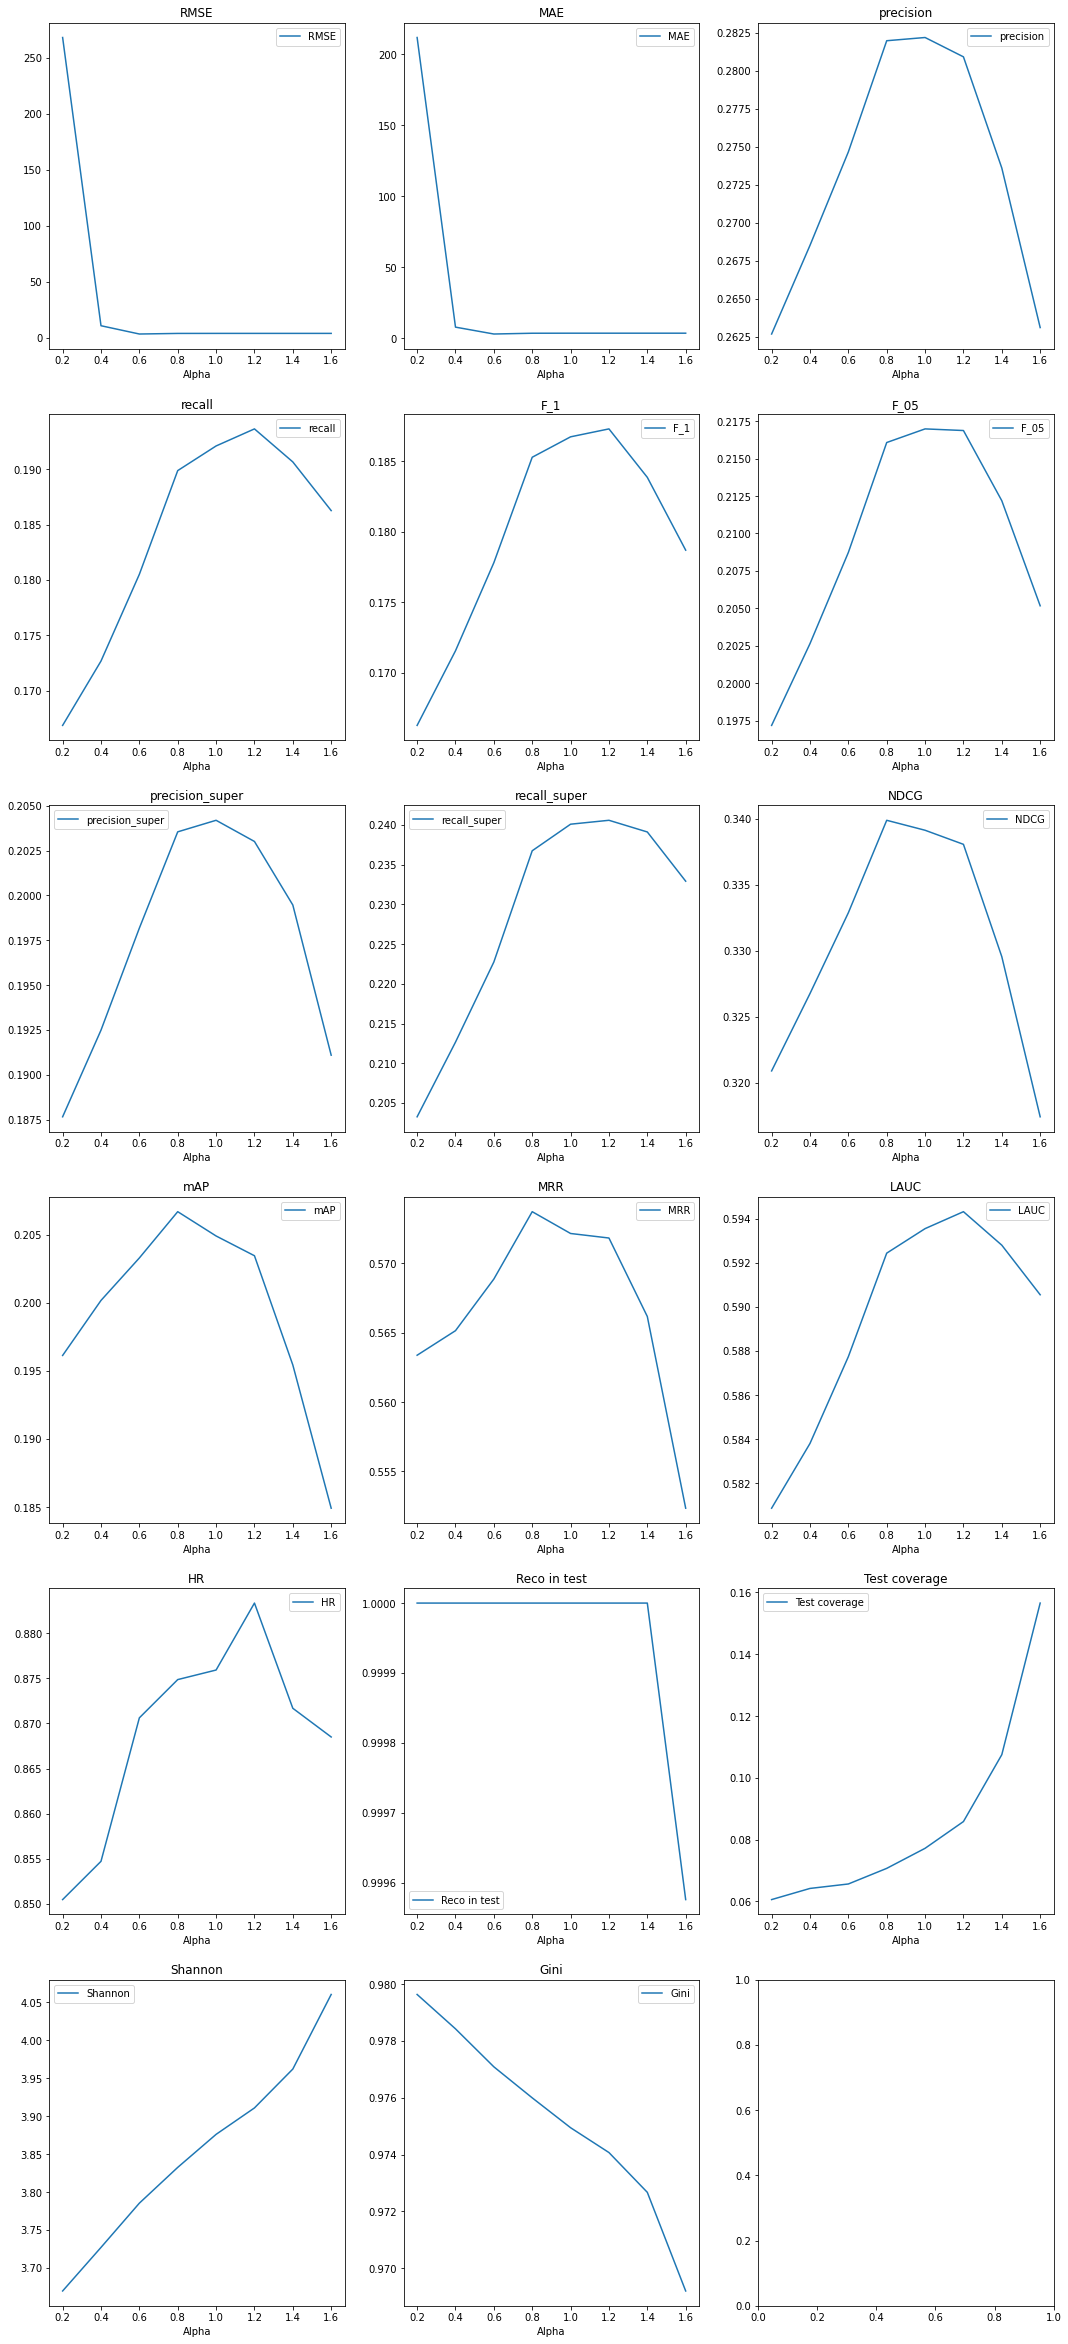

In [37]:
metrics=list(result.columns[[i not in ['Alpha'] for i in result.columns]])

charts_per_row=6
charts_per_column=3

fig, axes = plt.subplots(nrows=charts_per_row, ncols=charts_per_column,figsize=(18, 7*charts_per_row ))
import itertools
to_iter=[i for i in itertools.product(range(charts_per_row), range(charts_per_column))]

for i in range(len(metrics)):
    df=result[['Alpha', metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

##### Beta

In [14]:
from tqdm import tqdm
result=[]
for beta in tqdm([round(i,1) for i in np.arange(0,1,0.1)]):
    model=RP3Beta()
    model.fit(train_ui, alpha=1, beta=beta)
    reco=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
    estimations_df=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
    to_append=ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=np.array(reco),
            super_reactions=[4,5])
    to_append.insert(0, "Beta", beta)
    result.append(to_append)
    
result=pd.concat(result)
result

  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
458it [00:00, 4578.48it/s]
943it [00:00, 4542.31it/s]
 10%|█         | 1/10 [00:19<02:58, 19.88s/it]
0it [00:00, ?it/s]
463it [00:00, 4623.79it/s]
943it [00:00, 4327.22it/s]
 20%|██        | 2/10 [00:38<02:36, 19.53s/it]
0it [00:00, ?it/s]
450it [00:00, 4493.26it/s]
943it [00:00, 4423.59it/s]
 30%|███       | 3/10 [00:57<02:15, 19.30s/it]
0it [00:00, ?it/s]
943it [00:00, 4799.99it/s]
 40%|████      | 4/10 [01:16<01:55, 19.19s/it]
0it [00:00, ?it/s]
213it [00:00, 2129.95it/s]
943it [00:00, 3465.43it/s]
 50%|█████     | 5/10 [01:34<01:34, 19.00s/it]
0it [00:00, ?it/s]
393it [00:00, 3924.08it/s]
943it [00:00, 4149.53it/s]
 60%|██████    | 6/10 [01:53<01:15, 18.96s/it]
0it [00:00, ?it/s]
459it [00:00, 4583.01it/s]
943it [00:00, 4424.21it/s]
 70%|███████   | 7/10 [02:12<00:56, 18.76s/it]
0it [00:00, ?it/s]
943it [00:00, 4770.55it/s]
 80%|████████  | 8/10 [02:30<00:37, 18.69s/it]
0it [00:00, ?it/s]
943it [00:00, 5007.72it/s]
 90%|████

Beta      RMSE       MAE  precision    recall       F_1      F_05  \
0   0.0  3.702446  3.527273   0.282185  0.192092  0.186749  0.216980   
0   0.1  3.703312  3.528128   0.290138  0.197597  0.192259  0.223336   
0   0.2  3.703825  3.528636   0.297137  0.201202  0.196067  0.228169   
0   0.3  3.704130  3.528939   0.303499  0.204749  0.199901  0.232829   
0   0.4  3.704313  3.529120   0.308908  0.208811  0.203854  0.237241   
0   0.5  3.704422  3.529229   0.314316  0.211411  0.206768  0.240986   
0   0.6  3.704488  3.529295   0.314634  0.206209  0.204818  0.240159   
0   0.7  3.704528  3.529335   0.304136  0.187298  0.191990  0.228749   
0   0.8  3.704552  3.529360   0.266384  0.147571  0.158660  0.194838   
0   0.9  3.704567  3.529375   0.162354  0.076967  0.089233  0.114583   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   
0         0.210944      0.246153  0.347768  0.212034  0.581038  0.596328   
0         0.218026      0.252767  0.355655  0.219909  0.588904  0.598160   
0         0.225107      0.260797  0.363757  0.226825  0.599969  0.599964   
0         0.229614      0.266918  0.370758  0.232673  0.609385  0.602014   
0         0.237124      0.273416  0.378307  0.239297  0.622792  0.603327   
0         0.242489      0.273850  0.376438  0.238428  0.622042  0.600721   
0         0.238305      0.256201  0.358807  0.226808  0.593897  0.591207   
0         0.214485      0.209336  0.299850  0.184356  0.492852  0.571152   
0         0.134657      0.113253  0.160868  0.085486  0.243590  0.535405   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.875928      1.000000       0.077201  3.875892  0.974947  
0  0.884411      1.000000       0.085137  3.957416  0.972784  
0  0.886532      1.000000       0.094517  4.053212  0.969980  
0  0.888653      1.000000       0.105339  4.147779  0.966948  
0  0.895016      0.999894       0.132035  4.259682  0.962989  
0  0.903499      0.999046       0.168831  4.411281  0.956648  
0  0.897137      0.996394       0.212843  4.621938  0.945932  
0  0.868505      0.983033       0.256854  4.898568  0.928065  
0  0.803818      0.936373       0.341270  5.257397  0.895882  
0  0.580064      0.800106       0.415584  5.563910  0.857396

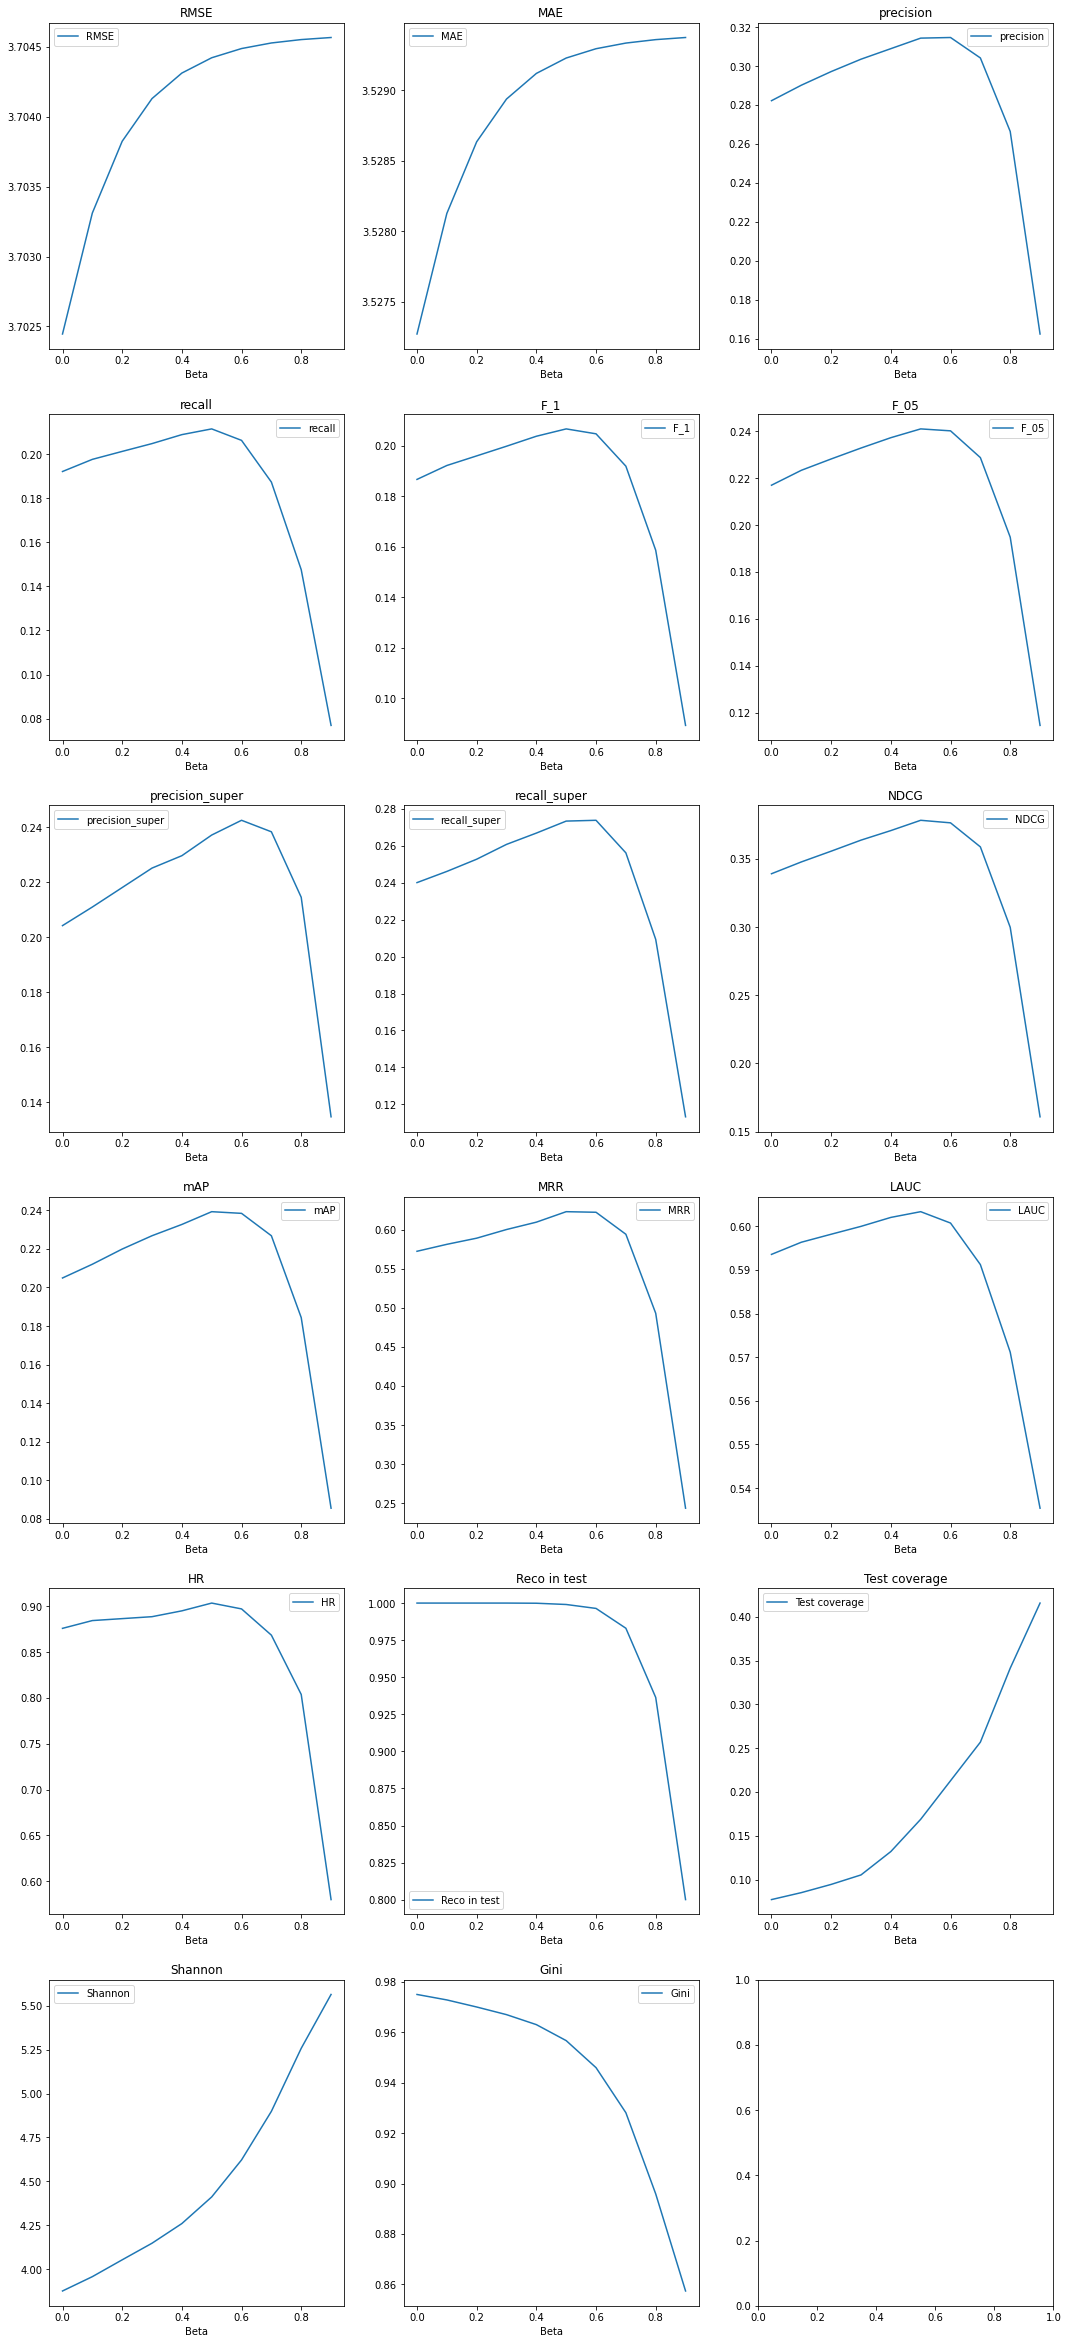

In [15]:
### import matplotlib.pyplot as plt

metrics=list(result.columns[[i not in ['Beta'] for i in result.columns]])

charts_per_row=6
charts_per_column=3

fig, axes = plt.subplots(nrows=charts_per_row, ncols=charts_per_column,figsize=(18, 7*charts_per_row ))
import itertools
to_iter=[i for i in itertools.product(range(charts_per_row), range(charts_per_column))]

for i in range(len(metrics)):
    df=result[['Beta', metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

# Check sample recommendations

In [36]:
train=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None, names=['user', 'item', 'rating', 'timestamp'])
items=pd.read_csv('./Datasets/ml-100k/movies.csv')

user=random.choice(list(set(train['user'])))

train_content=pd.merge(train, items, left_on='item', right_on='id')
display(train_content[train_content['user']==user][['user', 'rating', 'title', 'genres']]\
        .sort_values(by='rating', ascending=False)[:15])

reco = np.loadtxt('Recommendations generated/ml-100k/Self_RP3Beta_reco.csv', delimiter=',')
items=pd.read_csv('./Datasets/ml-100k/movies.csv')

# Let's ignore scores - they are not used in evaluation: 
reco_users=reco[:,:1]
reco_items=reco[:,1::2]
# Let's put them into one array
reco=np.concatenate((reco_users, reco_items), axis=1)

# Let's rebuild it user-item dataframe
recommended=[]
for row in reco:
    for rec_nb, entry in enumerate(row[1:]):
        recommended.append((row[0], rec_nb+1, entry))
recommended=pd.DataFrame(recommended, columns=['user','rec_nb', 'item'])

recommended_content=pd.merge(recommended, items, left_on='item', right_on='id')
recommended_content[recommended_content['user']==user][['user', 'rec_nb', 'title', 'genres']].sort_values(by='rec_nb')

user  rating                                              title  \
25689   645       5                                Citizen Kane (1941)   
46234   645       5                           Miller's Crossing (1990)   
29481   645       5                                      Psycho (1960)   
29861   645       5                       To Kill a Mockingbird (1962)   
24699   645       5             One Flew Over the Cuckoo's Nest (1975)   
64848   645       5                                 Taxi Driver (1976)   
31022   645       5                                  GoodFellas (1990)   
23585   645       5                                  Casablanca (1942)   
18551   645       5                                     Amadeus (1984)   
40333   645       5                                     Exotica (1994)   
42006   645       5  Dr. Strangelove or: How I Learned to Stop Worr...   
27477   645       5                          Young Frankenstein (1974)   
43025   645       5                       2001: A Space Odyssey (1968)   
12217   645       5                               Graduate, The (1967)   
42731   645       5                                      Brazil (1985)   

                                 genres  
25689                             Drama  
46234                             Drama  
29481         Horror, Romance, Thriller  
29861                             Drama  
24699                             Drama  
64848                   Drama, Thriller  
31022                      Crime, Drama  
23585               Drama, Romance, War  
18551                    Drama, Mystery  
40333                             Drama  
42006                       Sci-Fi, War  
27477                    Comedy, Horror  
43025  Drama, Mystery, Sci-Fi, Thriller  
12217                    Drama, Romance  
42731                            Sci-Fi

user  rec_nb                                      title  \
284   645.0       1                           Star Wars (1977)   
7185  645.0       2                               Fargo (1996)   
620   645.0       3             Raiders of the Lost Ark (1981)   
872   645.0       4           Silence of the Lambs, The (1991)   
2483  645.0       5                      Godfather, The (1972)   
6723  645.0       6            Empire Strikes Back, The (1980)   
1440  645.0       7                       Fugitive, The (1993)   
3288  645.0       8                           Toy Story (1995)   
8416  645.0       9  Indiana Jones and the Last Crusade (1989)   
2062  645.0      10                  Back to the Future (1985)   

                                              genres  
284          Action, Adventure, Romance, Sci-Fi, War  
7185                          Crime, Drama, Thriller  
620                                Action, Adventure  
872                                  Drama, Thriller  
2483                            Action, Crime, Drama  
6723  Action, Adventure, Drama, Romance, Sci-Fi, War  
1440                                Action, Thriller  
3288                   Animation, Children's, Comedy  
8416                               Action, Adventure  
2062                                  Comedy, Sci-Fi

# project task 6: generate recommendations of RP3Beta for hiperparameters found to optimize recall

In [38]:
# use better values than (1,0) for alpha and beta
# if you want you can also modify the model to consider different weights (we took as weights user ratings, maybe take ones or squares of ratings instead)
# save the outptut in 'Recommendations generated/ml-100k/Self_RP3Beta_estimations.csv'
# and 'Recommendations generated/ml-100k/Self_RP3Beta_reco.csv'

# project task 7 (optional): implement graph-based model of your choice 

In [45]:
# for example change length of paths in RP3beta
# save the outptut in 'Recommendations generated/ml-100k/Self_GraphTask_estimations.csv'
# and 'Recommendations generated/ml-100k/Self_GraphTask_reco.csv'